In [1]:
from DataGenerator import TimeSeriesGenerator, suddenDrift, generateSeasonality, generateTrend, incrementalDrift
from conditions import scenarios
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from grouped_series import ExperimentTracker    
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from TimeSeriesGradientBoosting import TimeSeriesGradientBoosting
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, RidgeCV

In [2]:
onehot1 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

onehot2 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

onehot3 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())


onehot4 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

hybrid_vars = [0,1, 2, 3, 4, 5, 6, 7, -3, -2, -1]
hybrid_model = TimeSeriesGradientBoosting(model1 = LinearRegression(), model2 = XGBRegressor(), model1_variables = hybrid_vars)
hybrid_model2 = TimeSeriesGradientBoosting(model1 = LinearRegression(), model2 = XGBRegressor(), model1_variables = hybrid_vars)

hybrid_xgb_pipe = Pipeline([
    ('preprocessor', onehot1),
    ('regressor', hybrid_model)
])

hybrid_xgb_pipe2 = Pipeline([
    ('preprocessor', onehot4),
    ('regressor', hybrid_model2)
])


sgd_pipe = Pipeline([
    ('preprocessor', onehot2),
    ('regressor', SGDRegressor())
])


sgd_pipe_online = Pipeline([
    ('preprocessor', onehot3),
    ('regressor', SGDRegressor())
])

switcher = [hybrid_xgb_pipe, sgd_pipe_online]

In [3]:
def full_run():
    products = []
    customers = []
    for i in range(2):
        product = TimeSeriesGenerator(size=365, amountOfVariables=7)
        customer = TimeSeriesGenerator(size=365, amountOfVariables=3)
        products.append(product)
        customers.append(customer)
    thesis = ExperimentTracker(products, customers, scenarios())
    thesis.runExperiment(algorithms=[hybrid_xgb_pipe2, switcher], algorithm_name=["LR", "Switcher"], LearningModes=["Offline", "Hybrid"])
    return thesis


In [4]:
thesis = full_run()

Finished experiment! Elapsed time: 0.4277536869049072, total Elapsed time: 0.4277536869049072, Algorithm: LR Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Fully observed, importance: Important
Finished experiment! Elapsed time: 0.2088789939880371, total Elapsed time: 0.6366326808929443, Algorithm: LR Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Half observed, importance: Important
Finished experiment! Elapsed time: 0.26984691619873047, total Elapsed time: 0.9064795970916748, Algorithm: LR Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Unobserved, importance: Important
Finished experiment! Elapsed time: 0.2628490924835205, total Elapsed time: 1.1693286895751953, Algorithm: LR Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Fully observed, importance: Medium
Finished experiment! Elapsed time: 0.3168191909790039, total Elapsed time: 1.4861478805541992, Algorithm: LR Type: Sudd

In [6]:
results = thesis.resultsToDF()

In [7]:
results[["Algorithm","SMAPE", "Drift type", "Drift time", "Drift magnitude"]].groupby(["Algorithm","Drift type", "Drift time", "Drift magnitude"]).aggregate(["mean", "std", "min", "max"])

SMAPE  \
                                                                 mean   
Algorithm Drift type        Drift time     Drift magnitude              
LR        Incremental Drift Fully observed Large             4.648333   
                                           Small             2.719167   
                            Half observed  Large             9.915000   
                                           Small             3.674167   
                            Unobserved     Large            10.300833   
                                           Small             3.747500   
          No Drift          No Drift       No Drift          2.460000   
          Sudden Drift      Fully observed Large             4.489167   
                                           Small             2.598333   
                            Half observed  Large             6.185833   
                                           Small             3.156667   
                            Unobserved     Large            12.192500   
                                           Small             3.999167   
          Sudden Shock      3 days         Large             2.795000   
                                           Small             2.520000   
                            7 days         Large             2.795000   
                                           Small             2.477500   
Switcher  Incremental Drift Fully observed Large             5.506667   
                                           Small             3.166667   
                            Half observed  Large             9.326667   
                                           Small             3.290000   
                            Unobserved     Large             9.808333   
                                           Small             3.368333   
          No Drift          No Drift       No Drift          2.517500   
          Sudden Drift      Fully observed Large             5.337500   
                                           Small             3.095000   
                            Half observed  Large             6.445000   
                                           Small             2.885833   
                            Unobserved     Large            11.576667   
                                           Small             3.504167   
          Sudden Shock      3 days         Large             3.105000   
                                           Small             2.597500   
                            7 days         Large             3.032500   
                                           Small             2.665000   

                                                                            \
                                                                 std   min   
Algorithm Drift type        Drift time     Drift magnitude                   
LR        Incremental Drift Fully observed Large            1.666187  2.29   
                                           Small            0.271309  2.36   
                            Half observed  Large            5.366484  2.66   
                                           Small            0.841854  2.31   
                            Unobserved     Large            5.469897  2.69   
                                           Small            0.848572  2.36   
          No Drift          No Drift       No Drift         0.090185  2.33   
          Sudden Drift      Fully observed Large            1.543399  2.34   
                                           Small            0.170178  2.31   
                            Half observed  Large            2.749190  2.40   
                                           Small            0.598701  2.30   
                            Unobserved     Large            6.824089  2.74   
                                           Small            1.032028  2.36   
          Sudden Shock      3 days         Large            0.297153  2.56   
                                    

In [8]:
results.sort_values("SMAPE", ascending=False)   

,Algorithm,Dropped variable,Drift type,Drift magnitude,Variable importance,Drift time,MSE,SMAPE
216,Switcher,0.0,Sudden Drift,Large,Important,Unobserved,2141.143423,30.27
257,Switcher,3.0,Sudden Drift,Large,Important,Unobserved,2109.324766,29.81
52,LR,0.0,Sudden Drift,Large,Important,Unobserved,2065.635284,29.67
134,LR,6.0,Sudden Drift,Large,Important,Unobserved,2068.642374,29.56
298,Switcher,6.0,Sudden Drift,Large,Important,Unobserved,2063.530495,29.50
...,...,...,...,...,...,...,...,...
200,Switcher,NaN,No Drift,No Drift,No Drift,No Drift,16.065908,2.55
323,Switcher,6.0,No Drift,No Drift,No Drift,No Drift,15.463177,2.54
311,Switcher,6.0,Incremental Drift,Small,Unimportant,Fully observed,15.711803,2.53
293,Switcher,6.0,Sudden Drift,Small,Unimportant,Fully observed,15.798491,2.53


Next up is changepoint/drift detection!
Let's start with doing it on a single series and then ramp up complexity to multivariate cases

In [40]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.consts import TimeSeriesData

In [41]:
test_prod = TimeSeriesGenerator(size=365, amountOfVariables=10)
#generateTrend(test_prod, indices=1, magnitude=3)
suddenDrift(test_prod, variables=0, magnitude=3, time=140)
generateSeasonality(test_prod, 6, 2)
test_prod = test_prod.toDataFrame()
test_prod = test_prod.astype(float)

In [42]:
tsd = TimeSeriesData(value= test_prod["Response"], time = test_prod.index)


In [43]:
det = BOCPDetector(tsd)
changepoint = det.detector(threshold=0.9)

C:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

C:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



In [44]:
changepoint

[BOCPDChangePoint(start_time: 2017-05-20T00:00:00.000000000, end_time: 2017-05-20T00:00:00.000000000, confidence: 0.9789737411774339, model: BOCPDModelType.NORMAL_KNOWN_MODEL, ts_name: Response),
 BOCPDChangePoint(start_time: 2017-05-21T00:00:00.000000000, end_time: 2017-05-21T00:00:00.000000000, confidence: 0.9799999940954781, model: BOCPDModelType.NORMAL_KNOWN_MODEL, ts_name: Response)]

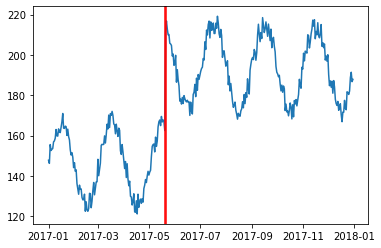

In [45]:
det.plot(changepoint);

In [46]:
test_prod.iloc[[110]]

,Variable_0,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Response,year,week,day
2017-04-21,25.576258,26.605038,2.111045,15.707047,21.914527,23.963883,24.406188,10.019339,30.431647,24.41993,128.512764,2017.0,16.0,5.0
